Data shape: (691, 37)

First few rows of the dataset:
   Store ID Pop class       Sales Centre Type   Climate  Total Store Sq Ft  \
0         1  Suburban  1345251.88      Outlet    Frigid             4735.0   
1         2     Urban  1669906.40        Mall  Moderate             8068.0   
2         3     Urban  2528042.74      Outlet       Hot             4583.2   
3         4  Suburban  1281613.45      Outlet  Moderate             5772.3   
4         5     Urban  1278092.87      Outlet      Cold             3503.0   

   Sales Floor Sq Ft  Girls Sq Ft  Guys Sq Ft  Accessories Sq Ft  ...  \
0             4015.6       2032.3       947.7              747.5  ...   
1             7128.6       2735.2      1788.1             1251.3  ...   
2             3961.7       2082.9      1030.2              551.7  ...   
3             4713.0       2140.1      1149.0             1162.2  ...   
4             3239.0       1870.6       769.5              483.5  ...   

  Poverty: In poverty Male 14 to 35 Cr

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

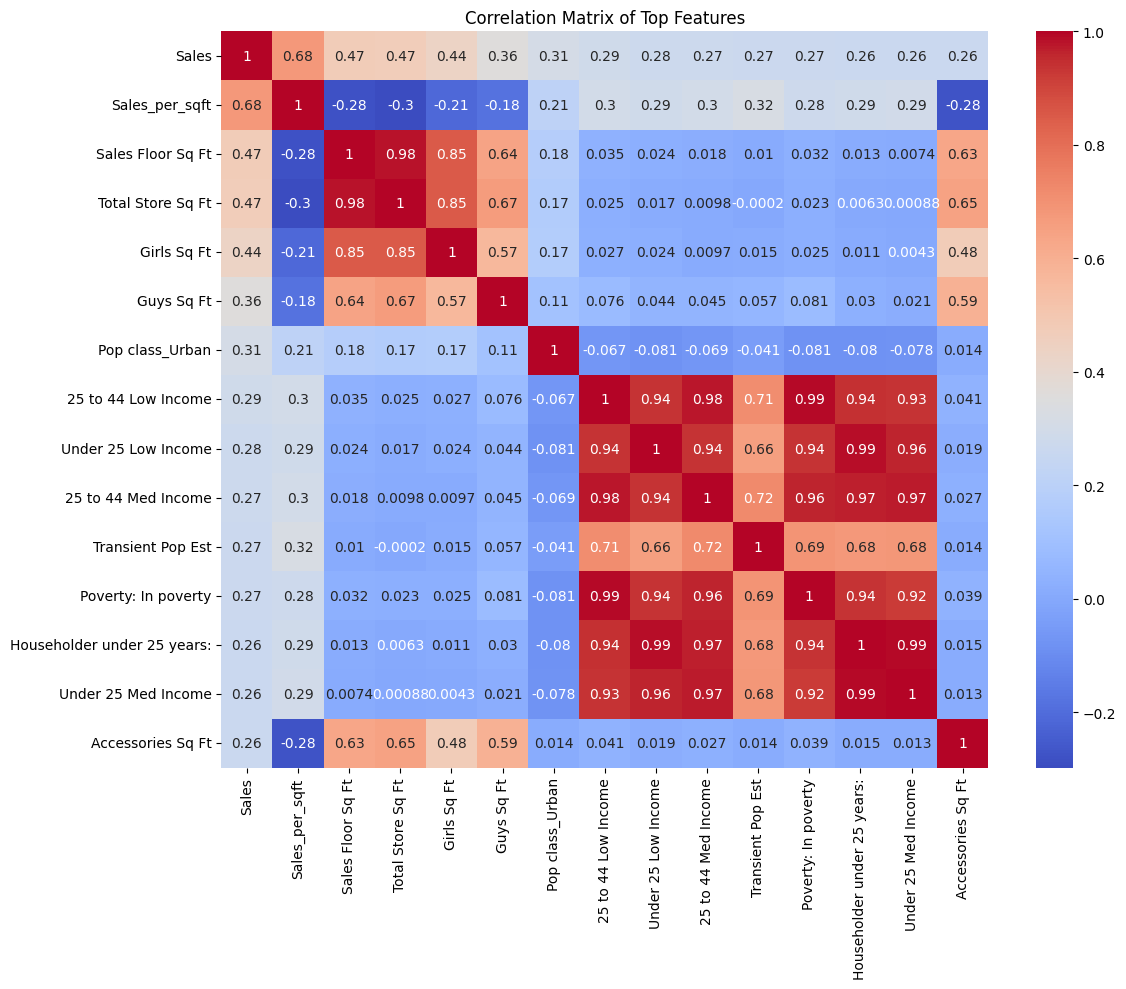

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

file_path = "DS Internship - Modeling - Data.xlsx"
df = pd.read_excel(file_path)

print("Data shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

print("\nMissing values before handling:")
print(df.isnull().sum())

df['Girls Sq Ft'] = df['Girls Sq Ft'].fillna(df['Girls Sq Ft'].median())
df['Guys Sq Ft'] = df['Guys Sq Ft'].fillna(df['Guys Sq Ft'].median())
df['Accessories Sq Ft'] = df['Accessories Sq Ft'].fillna(df['Accessories Sq Ft'].median())


print("\nMissing values after handling square footage:")
print(df[['Girls Sq Ft', 'Guys Sq Ft', 'Accessories Sq Ft']].isnull().sum())

categorical_cols = ['Pop class', 'Centre Type', 'Climate', 'Guys Segmentation', 'Girls Segmentation']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


if 'ChangeDate' in df.columns:
    df_encoded['ChangeDate'] = pd.to_datetime(df_encoded['ChangeDate'], errors='coerce')
    years_since_change = (pd.Timestamp('2019-12-31') - df_encoded['ChangeDate']).dt.days / 365
    median_years = years_since_change.median()
    df_encoded['YearsSinceChange'] = years_since_change.fillna(median_years)
    print(f"\nMedian years since change (used for missing values): {median_years:.2f}")
    df_encoded.drop('ChangeDate', axis=1, inplace=True)

columns_to_drop = ['Store ID', 'ChangeMade']
df_encoded.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

df_encoded['Sales_per_sqft'] = df_encoded['Sales'] / df_encoded['Total Store Sq Ft']
df_encoded['Sales_floor_ratio'] = df_encoded['Sales Floor Sq Ft'] / df_encoded['Total Store Sq Ft']
df_encoded['Girls_floor_ratio'] = df_encoded['Girls Sq Ft'] / df_encoded['Sales Floor Sq Ft']
df_encoded['Guys_floor_ratio'] = df_encoded['Guys Sq Ft'] / df_encoded['Sales Floor Sq Ft']
df_encoded['Accessories_floor_ratio'] = df_encoded['Accessories Sq Ft'] / df_encoded['Sales Floor Sq Ft']
df_encoded['Youth_ratio'] = df_encoded['Total Pop 14 to 35 CrYr'] / df_encoded['Population Est CrYr']
df_encoded['Income_per_capita'] = df_encoded['Average Household Income CrYr'] / df_encoded['Population Est CrYr']

inf_check = np.isinf(df_encoded).any().any()
nan_check = df_encoded.isnull().sum().sum()
print(f"\nInfinities in dataframe: {inf_check}")
print(f"NaNs in dataframe: {nan_check}")

if inf_check or nan_check > 0:
    print("Replacing infinities with NaN and filling NaNs with median values...")
    df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan)
    for col in df_encoded.columns:
        if df_encoded[col].isnull().sum() > 0:
            df_encoded[col] = df_encoded[col].fillna(df_encoded[col].median())

correlation = df_encoded.corr()['Sales'].sort_values(ascending=False)
print("\nTop correlations with Sales:")
print(correlation.head(15))
print("\nLowest correlations with Sales:")
print(correlation.tail(10))

plt.figure(figsize=(12, 10))
top_corr_features = correlation.index[:15]
correlation_matrix = df_encoded[top_corr_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png')


X = df_encoded.drop('Sales', axis=1)
y = df_encoded['Sales']

print("\nData types in features:")
print(X.dtypes.value_counts())
print("\nAny non-numeric columns:", X.select_dtypes(exclude=['float64', 'int64']).columns.tolist())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_const = add_constant(X_train)

print(f"Missing values in X_const: {X_const.isnull().sum().sum()}")

vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
try:
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    print("\nVariance Inflation Factors:")
    print(vif_data.sort_values('VIF', ascending=False).head(15))

    high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
    if 'const' in high_vif_features:
        high_vif_features.remove('const')
    print(f"\nRemoving {len(high_vif_features)} features with high VIF (>10):")
    print(high_vif_features)

    X_train_filtered = X_train.drop(high_vif_features, axis=1)
    X_test_filtered = X_test.drop(high_vif_features, axis=1)
except Exception as e:
    print(f"Error in VIF calculation: {e}")
    print("Proceeding without VIF-based feature selection")
    X_train_filtered = X_train
    X_test_filtered = X_test

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

X_train_const = sm.add_constant(X_train_filtered)
initial_model = sm.OLS(y_train, X_train_const).fit()
print("\nInitial model summary:")
print(initial_model.summary())


kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_model = LinearRegression()
cv_scores = cross_val_score(lr_model, X_train_filtered, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())
print(f"\nCross-validated RMSE: ${cv_rmse:.2f}")

def backward_elimination(X, y, significance_level=0.05):
    """Perform backward elimination to select significant features"""
    features = list(X.columns)
    while len(features) > 0:
        X_with_const = sm.add_constant(X[features])
        model = sm.OLS(y, X_with_const).fit()
        p_values = model.pvalues[1:]
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            eliminate_feature = p_values.idxmax()
            features.remove(eliminate_feature)
            print(f"Removed: {eliminate_feature} with p-value: {max_p_value:.4f}")
        else:
            break
    return features, model

significant_features, final_model = backward_elimination(X_train_filtered, y_train)
print("\nSignificant features after backward elimination:")
print(significant_features)
print("\nFinal model summary:")
print(final_model.summary())

X_test_final = sm.add_constant(X_test_filtered[significant_features])
y_pred = final_model.predict(X_test_final)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = calculate_mape(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


residuals = y_test - y_pred
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')


plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

plt.tight_layout()
plt.savefig('residual_analysis.png')

plt.figure(figsize=(12, 8))
coef_df = pd.DataFrame({
    'Feature': final_model.model.exog_names[1:],
    'Coefficient': final_model.params[1:],
    'P-value': final_model.pvalues[1:],
    'Significant': final_model.pvalues[1:] < 0.05
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Feature Importance (Coefficients)')
plt.tight_layout()
plt.savefig('feature_importance.png')


df_test = X_test.copy()
df_test['Sales'] = y_test
df_test['Predicted_Sales'] = y_pred
df_test['Absolute_Error'] = np.abs(df_test['Sales'] - df_test['Predicted_Sales'])
df_test['Percentage_Error'] = (df_test['Absolute_Error'] / df_test['Sales']) * 100

if 'Total Store Sq Ft' in df_test.columns:
    df_test['Store_Size'] = pd.qcut(df_test['Total Store Sq Ft'], 3, labels=['Small', 'Medium', 'Large'])


    mape_by_size = df_test.groupby('Store_Size')['Percentage_Error'].mean()

    print("\nMAPE by Store Size:")
    print(mape_by_size)


    plt.figure(figsize=(8, 6))
    mape_by_size.plot(kind='bar')
    plt.title('MAPE by Store Size')
    plt.xlabel('Store Size')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.tight_layout()
    plt.savefig('mape_by_store_size.png')

output_file = "ABC_Store_Sales_Model_Results.xlsx"

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R-squared', 'MAPE', 'Cross-validated RMSE'],
    'Value': [mae, mse, rmse, r2, mape, cv_rmse],
    'Description': [
        'Mean Absolute Error - Average absolute difference between predicted and actual sales',
        'Mean Squared Error - Average squared difference between predicted and actual sales',
        'Root Mean Squared Error - Square root of MSE, more interpretable in original units',
        'Coefficient of determination - Proportion of variance explained by the model',
        'Mean Absolute Percentage Error - Average percentage difference between predicted and actual sales',
        'Cross-validated RMSE - Root mean squared error from 5-fold cross-validation'
    ]
})

coef_df = pd.DataFrame({
    'Feature': final_model.model.exog_names,
    'Coefficient': final_model.params,
    'P-value': final_model.pvalues,
    'Significant': final_model.pvalues < 0.05
})
coef_df = coef_df.sort_values('P-value')


predictions_df = pd.DataFrame({
    'Actual_Sales': y_test,
    'Predicted_Sales': y_pred,
    'Absolute_Error': np.abs(y_test - y_pred),
    'Percentage_Error': (np.abs(y_test - y_pred) / y_test) * 100
})


with pd.ExcelWriter(output_file) as writer:
    metrics_df.to_excel(writer, sheet_name='Model Performance', index=False)
    coef_df.to_excel(writer, sheet_name='Significant Features', index=False)
    predictions_df.to_excel(writer, sheet_name='Test Predictions', index=False)

    if 'Store_Size' in df_test.columns:
        mape_by_size_df = pd.DataFrame(mape_by_size).reset_index()
        mape_by_size_df.columns = ['Store Size', 'MAPE (%)']
        mape_by_size_df.to_excel(writer, sheet_name='MAPE by Store Size', index=False)

print(f"\nModel results saved to {output_file}")

print("\nKey Drivers of Sales (Most significant features):")
key_drivers = coef_df[coef_df['Significant'] == True].sort_values(by='Coefficient', ascending=False)
print(key_drivers[['Feature', 'Coefficient', 'P-value']].head(10))

import numpy as np
import pandas as pd
import statsmodels.api as sm

def preprocess_data(X, y):
    X = pd.get_dummies(X, drop_first=True)

    X = X.dropna()
    y = y.dropna()

    X = X.astype(float)
    y = y.astype(float)

    return X, y

X_train_filtered, y_train = preprocess_data(X_train_filtered, y_train)

X_train_filtered = np.asarray(X_train_filtered, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)


X_train_const = sm.add_constant(X_train_filtered)


initial_model = sm.OLS(y_train, X_train_const).fit()


print("\nInitial model summary:")
print(initial_model.summary())


In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def preprocess_data(X, y):
    X = pd.get_dummies(X, drop_first=True)

    X = X.dropna()
    y = y.dropna()

    X = X.astype(float)
    y = y.astype(float)

    return X, y

X_train_filtered, y_train = preprocess_data(X_train_filtered, y_train)

X_train_filtered = np.asarray(X_train_filtered, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)


X_train_const = sm.add_constant(X_train_filtered)


initial_model = sm.OLS(y_train, X_train_const).fit()


print("\nInitial model summary:")
print(initial_model.summary())



Initial model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     312.3
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        05:25:53   Log-Likelihood:                -7059.7
No. Observations:                 552   AIC:                         1.421e+04
Df Residuals:                     505   BIC:                         1.442e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.792e+06   7.46